In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch import optim

numpy = lambda x : x.detach().cpu().numpy().squeeze()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import pyrtools as pt
import plenoptic as po

%load_ext autoreload
%autoreload 2

In [2]:
# Preprocessing
# np_img1 = plt.imread('../data/curie.pgm').astype('float')
np_img1 = plt.imread('../data/einstein.png').astype('float')[:,:,0]
# np_img1 = plt.imread('../data/cat7-elephant1.png').astype('float')

# normalize values between 0-1
np_img1 = po.rescale(np_img1)

# if len(np_img1.shape) == 2:                  # if no channel dimension exists
#     np_img1 = np.expand_dims(np_img1, axis=-1)
# np_img1 = np.transpose(np_img1, (2, 0, 1))   # adjust dimensions for pytorch
# np_img1 = np.expand_dims(np_img1, axis=0)    # add batch dimension
# np_img1 = np_img1 / 255.0                    # normalize values between 0-1
# np_img1 = np_img1.astype(np.float32)         # adjust type

# img1 = torch.from_numpy(np_img1)
img1 = torch.tensor(np_img1, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
img2 = torch.rand_like(img1, requires_grad=True).to(device)

img1.requires_grad = False
img2.requires_grad = True

In [4]:
# loss_func = lambda x, y: 1 - po.synth.ssim(x, y)
# loss_func = lambda x, y: 1 - po.synth.msssim(x, y)
# loss_func = po.synth.nlpd
loss_func = po.synth.nspd

value = loss_func(img1, img2)
print("Initial distance: %.5f" % (value.item()))
assert value.requires_grad

Initial distance: 0.85521


In [5]:
optimizer = optim.Adam([img2], lr=0.01, amsgrad=True)

# MSSSIM yields higher values for worse results,
# because noise is removed in scales with lower resolutions

# threshold = 0.5
threshold = 0.001
max_iter = 500

I = []
l = []
i = 0
while value > threshold and i < max_iter:

    i += 1
    optimizer.zero_grad()
    loss = loss_func(img1, img2)
    value = loss.item()
    print('Current distance = %.5f' % value)
    loss.backward()
    optimizer.step()
    
    l.append(value)
    I.append(numpy(img2).copy())

Current distance = 0.85521
Current distance = 0.80062
Current distance = 0.75867
Current distance = 0.72552
Current distance = 0.69517
Current distance = 0.66842
Current distance = 0.64785
Current distance = 0.62929
Current distance = 0.61175
Current distance = 0.59674
Current distance = 0.58327
Current distance = 0.57192
Current distance = 0.56207
Current distance = 0.55295
Current distance = 0.54407
Current distance = 0.53548
Current distance = 0.52625
Current distance = 0.51738
Current distance = 0.50904
Current distance = 0.50173
Current distance = 0.49448
Current distance = 0.48745
Current distance = 0.48039
Current distance = 0.47406
Current distance = 0.46596
Current distance = 0.46024
Current distance = 0.45470
Current distance = 0.44915
Current distance = 0.44313
Current distance = 0.43685
Current distance = 0.43137
Current distance = 0.42621
Current distance = 0.42126
Current distance = 0.41595
Current distance = 0.41041
Current distance = 0.40667
Current distance = 0.40096
C

Current distance = 0.14651
Current distance = 0.14549
Current distance = 0.14543
Current distance = 0.14515
Current distance = 0.14457
Current distance = 0.14369
Current distance = 0.14393
Current distance = 0.14407
Current distance = 0.14422
Current distance = 0.14363
Current distance = 0.14347
Current distance = 0.14324
Current distance = 0.14278
Current distance = 0.14319
Current distance = 0.14151
Current distance = 0.14134
Current distance = 0.14042
Current distance = 0.14016
Current distance = 0.14004
Current distance = 0.13964
Current distance = 0.13939
Current distance = 0.13911
Current distance = 0.13894
Current distance = 0.13845
Current distance = 0.13717
Current distance = 0.13664
Current distance = 0.13653
Current distance = 0.13586
Current distance = 0.13625
Current distance = 0.13601
Current distance = 0.13595
Current distance = 0.13673
Current distance = 0.13654
Current distance = 0.13581
Current distance = 0.13544
Current distance = 0.13536
Current distance = 0.13477
C

Difference statistics:
  Range: [-1, 0]
  Mean: -0.113685,  Stdev (rmse): 0.261178,  SNR (dB): -4.075492

 1 - ssim: 0.80593 
 1 - ms-ssim: 0.42707 
 nlpd: 2.12322 
 nspd: 0.10713 



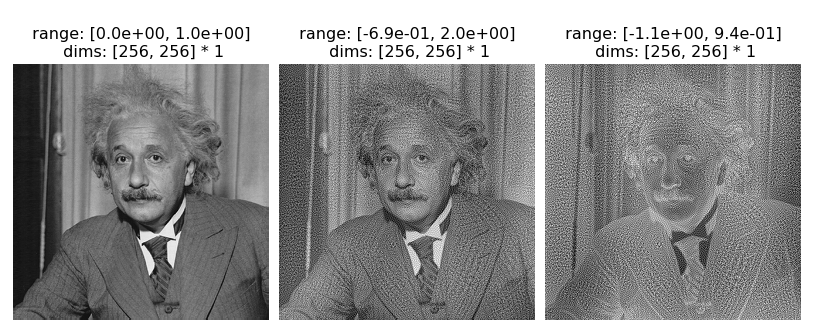

In [6]:
pt.imshow([numpy(img1), numpy(img2), numpy(img1) - numpy(img2)]);
pt.image_compare(numpy(img1), numpy(img2))

print('\n 1 - ssim: %.5f \n 1 - ms-ssim: %.5f \n nlpd: %.5f \n nspd: %.5f \n' % (
    1 - po.synth.ssim(img1, img2), 1 - po.synth.msssim(img1, img2), po.synth.nlpd(img1, img2), po.synth.nspd(img1, img2)))

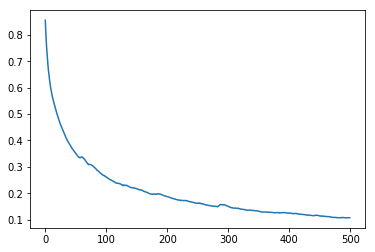

In [7]:
plt.plot(l)

In [8]:
pt.animshow(np.array(I), 25)

In [ ]:
# def post_process(img):
#     img = img.detach().cpu().numpy()
#     img = np.transpose(np.squeeze(img, axis=0), (1, 2, 0))
#     img = np.squeeze(img)     # works if grayscale
#     return img

# # Post processing
# img1np = post_process(img1)
# img2 = torch.sigmoid(img2)
# img2np = post_process(img2)

# import matplotlib.pyplot as plt
# cmap = 'gray' if len(img1np.shape) == 2 else None
# plt.subplot(1, 2, 1)
# plt.imshow(img1np, cmap=cmap)
# plt.title('Original')
# plt.subplot(1, 2, 2)
# plt.imshow(img2np, cmap=cmap)
# plt.title('Generated, metric: {:.3f}'.format(value))
# plt.show()